# Signal and noise histograms per plan

In [1]:
%matplotlib inline

import numpy as np
import scipy
import math
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 8)

import sys
sys.path.append("../")

import datapipe
from datapipe.io.images import image_generator
from datapipe.denoising.wavelets_mrtransform import wavelet_transform

In [2]:
from datapipe.denoising.inverse_transform_sampling import EmpiricalDistribution
import datapipe.denoising.cdf

## Common functions

In [3]:
IMG_SIZE = 7

def plot_hist(data_list, threshold_list, data_list2=None, suptitle=None, title_list=None, log=True):
    num_imgs = len(data_list)
    
    fig, ax_list = plt.subplots(ncols=num_imgs, figsize=(num_imgs*IMG_SIZE, IMG_SIZE), squeeze=True)
    
    if title_list is None:
        title_list = [str(i) for i in range(len(data_list))]

    for data, threshold, title, ax in zip(data_list, threshold_list, title_list, ax_list):
        ax.set_title(title)
        
        data_min = min(data)
        data_max = max(data)
        bins = np.arange(math.floor(data_min), math.ceil(data_max) + 1)

        ax.hist(data, log=log, bins=bins)
        ax.axvline(threshold, color="r")
    
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.tick_params(axis='both', which='minor', labelsize=16)
        
    if data_list2 is not None:
        for data, ax in zip(data_list2, ax_list):
            data_min = min(data)
            data_max = max(data)
            bins = np.arange(math.floor(data_min), math.ceil(data_max) + 1)

            ax.hist(data, log=log, bins=bins, alpha=0.5)

    plt.suptitle(suptitle, fontsize=16)
    
    plt.show()

In [4]:
def make_samples(path_list,
                 tel_filter_list=None,
                 max_num_images=None):

    in_sample_list = [[] for i in range(4)]
    ref_sample_list = [[] for i in range(4)]
    noise_sample_list = [[] for i in range(4)]
    
    noise_injection = True

    for images, metadata in image_generator(path_list,
                                            max_num_images=max_num_images,
                                            tel_filter_list=tel_filter_list):

        # Make ref, input and noise images #################

        in_img = images["input_image"]
        ref_img = images["reference_image"]

        noise_img = np.copy(in_img)
        noise_img[ref_img != 0.] = np.nan

        # Inject noise in NaN pixels #######################

        in_nan_mask = np.isnan(in_img)
        ref_nan_mask = np.isnan(ref_img)
        noise_nan_mask = np.isnan(noise_img)

        if noise_injection:
            if metadata['cam_id'] == 'ASTRI':
                dist = EmpiricalDistribution(datapipe.denoising.cdf.ASTRI_CDF_FILE)

            elif metadata['cam_id'] in ('GATE', 'CHEC'):
                dist = EmpiricalDistribution(datapipe.denoising.cdf.GCT_CDF_FILE)

            elif metadata['cam_id'] == 'DigiCam':
                dist = EmpiricalDistribution(datapipe.denoising.cdf.DIGICAM_CDF_FILE)

            elif metadata['cam_id'] == 'FlashCam':
                dist = EmpiricalDistribution(datapipe.denoising.cdf.FLASHCAM_CDF_FILE)

            elif metadata['cam_id'] == 'NectarCam':
                dist = EmpiricalDistribution(datapipe.denoising.cdf.NECTARCAM_CDF_FILE)

            elif metadata['cam_id'] == 'LSTCam':
                dist = EmpiricalDistribution(datapipe.denoising.cdf.LSTCAM_CDF_FILE)

            else:
                raise ValueError("Wrong cam_id", metadata['cam_id'])

            in_img[in_nan_mask] = dist.rvs(size=np.count_nonzero(in_nan_mask))

            ref_img[ref_nan_mask] = 0.

            noise_img[noise_nan_mask] = dist.rvs(size=np.count_nonzero(noise_nan_mask))

        # Apply Wavelet transform ##########################

        in_plan_imgs = wavelet_transform(in_img)
        ref_plan_imgs = wavelet_transform(ref_img)
        noise_plan_imgs = wavelet_transform(noise_img)

        # "Normalize plans" ################################

        for plan in in_plan_imgs:
            std = plan.std()
            plan /= std

        for plan in ref_plan_imgs:
            std = plan.std()
            plan /= std

        for plan in noise_plan_imgs:
            std = plan.std()
            plan /= std

        # Filter NaN pixels ################################

        for plan in in_plan_imgs:
            plan[in_nan_mask] = np.nan

        for plan in ref_plan_imgs:
            plan[ref_nan_mask] = np.nan

        for plan in noise_plan_imgs:
            plan[noise_nan_mask] = np.nan

        # Add samples ######################################

        for plan_index in range(4):
            in_sample_list[plan_index].extend(in_plan_imgs[plan_index][np.logical_not(in_nan_mask)].tolist())

        for plan_index in range(4):
            ref_sample_list[plan_index].extend(ref_plan_imgs[plan_index][np.logical_not(ref_nan_mask)].tolist())

        for plan_index in range(4):
            noise_sample_list[plan_index].extend(noise_plan_imgs[plan_index][np.logical_not(noise_nan_mask)].tolist())
    
    return in_sample_list, ref_sample_list, noise_sample_list

## SST-1M

In [5]:
%%time

path_list = ['/Users/jdecock/data/sst1m_mini_array_konrad/fits/sst1m/gamma/']

digicam_samples = make_samples(path_list,
                               tel_filter_list=None,
                               max_num_images=2000)

CPU times: user 1min 18s, sys: 23.8 s, total: 1min 42s
Wall time: 24min 47s


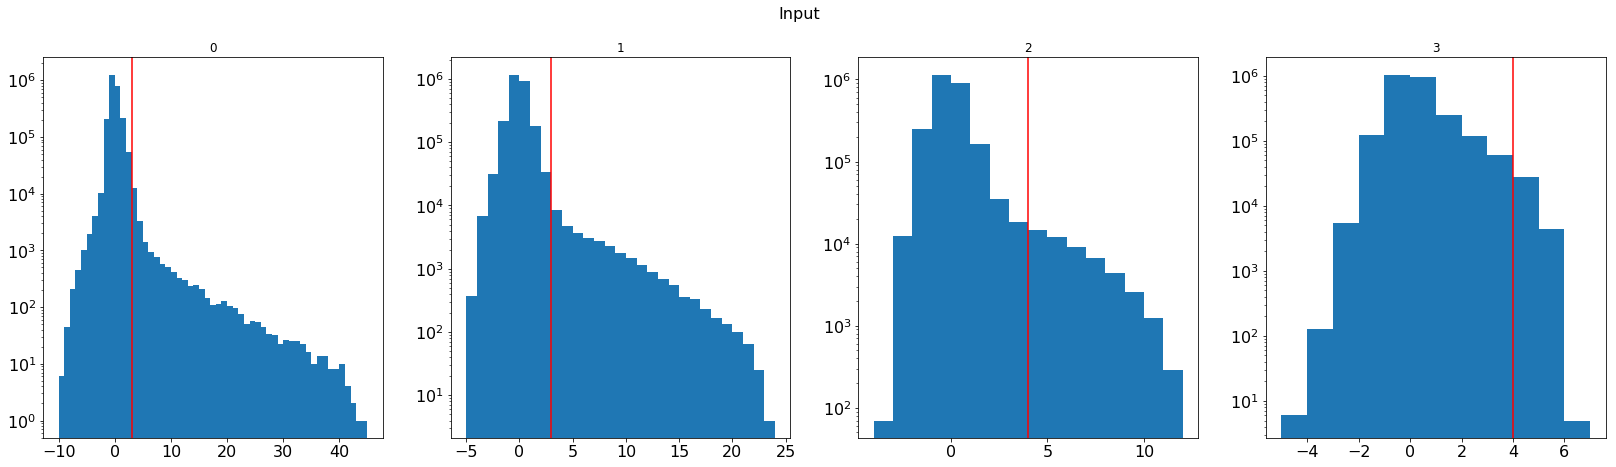

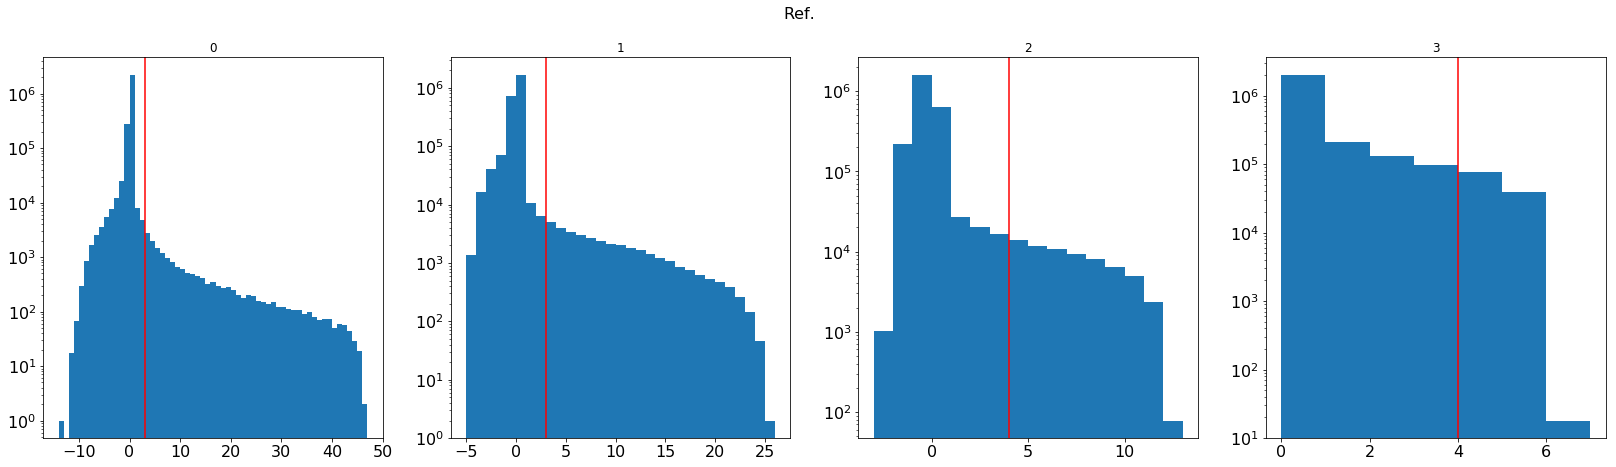

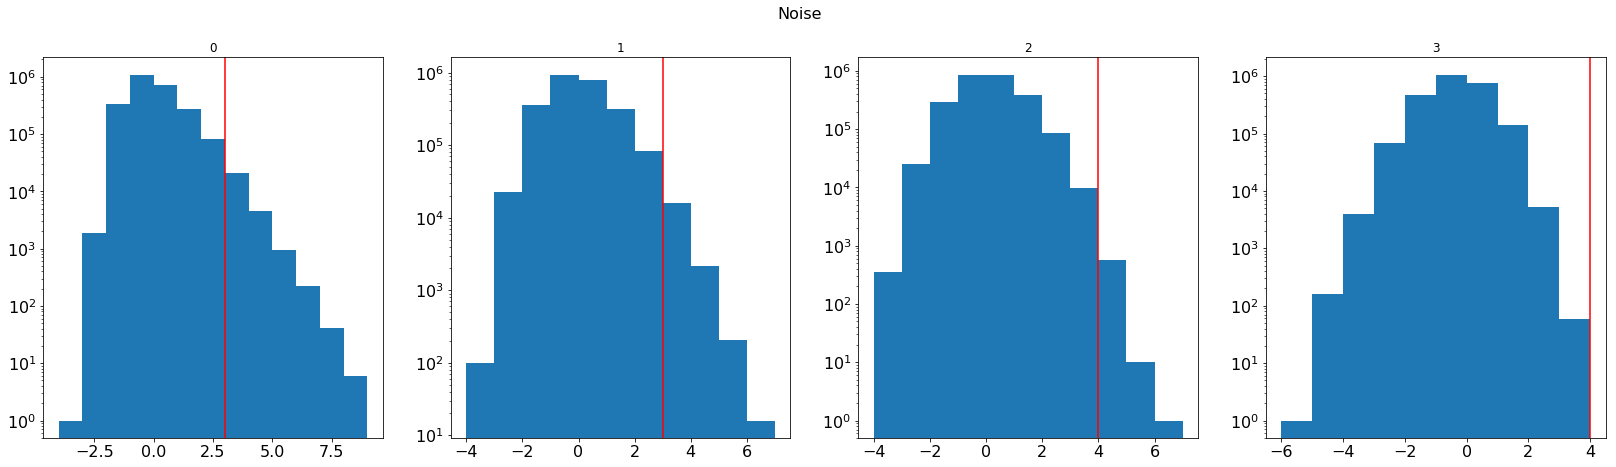

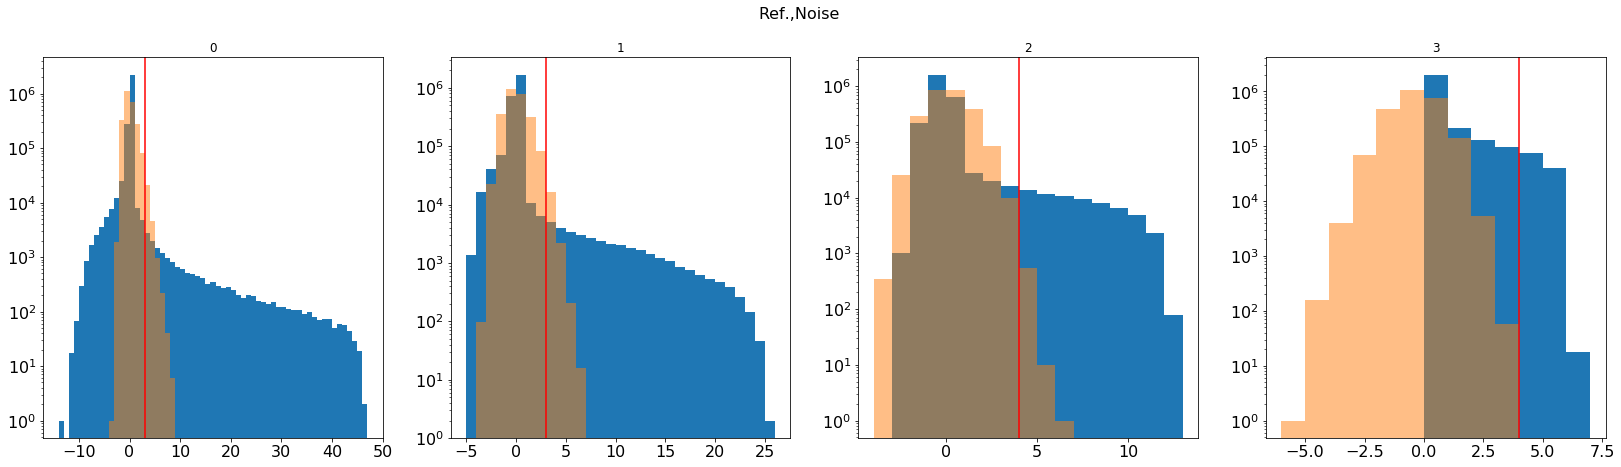

In [6]:
digicam_thresholds = [3, 3, 4, 4]
#digicam_thresholds = [2.5, 2.5, 4.5, 1.]

plot_hist(digicam_samples[0], threshold_list=digicam_thresholds, suptitle="Input")
plot_hist(digicam_samples[1], threshold_list=digicam_thresholds, suptitle="Ref.")
plot_hist(digicam_samples[2], threshold_list=digicam_thresholds, suptitle="Noise")

plot_hist(digicam_samples[1], threshold_list=digicam_thresholds, data_list2=digicam_samples[2], suptitle="Ref.,Noise")

## NectarCam

In [7]:
%%time

path_list = ['/Users/jdecock/data/grid_prod3b_north/fits/nectarcam/gamma/']

nectarcam_samples = make_samples(path_list,
                                 tel_filter_list=None,
                                 max_num_images=2000)

CPU times: user 1min 20s, sys: 32.7 s, total: 1min 53s
Wall time: 29min 40s


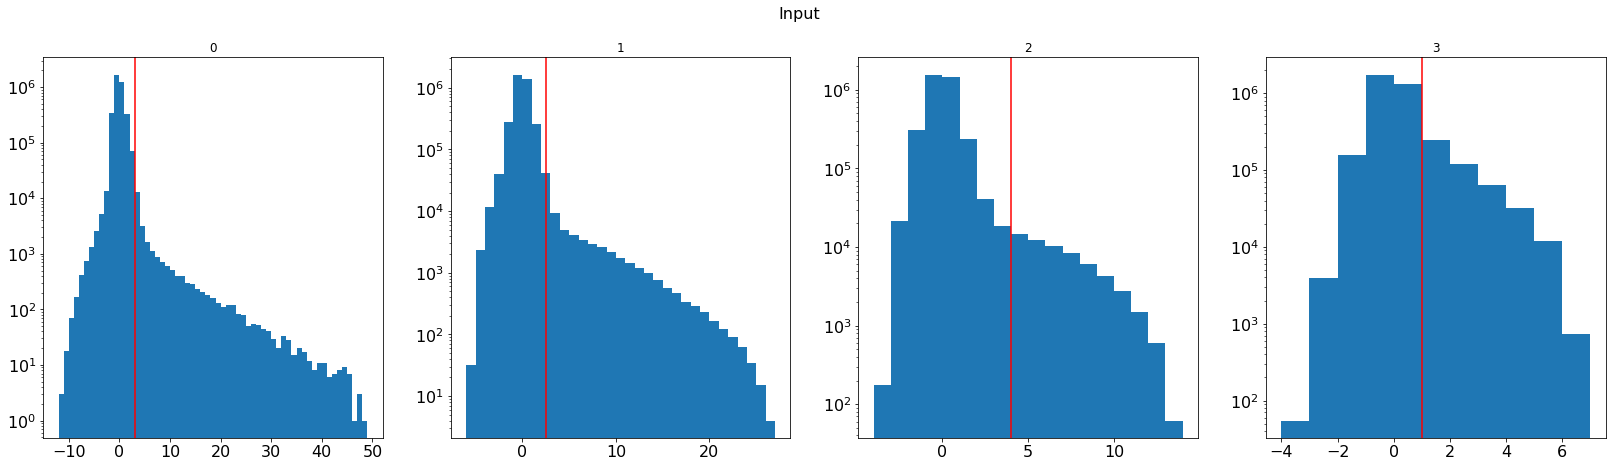

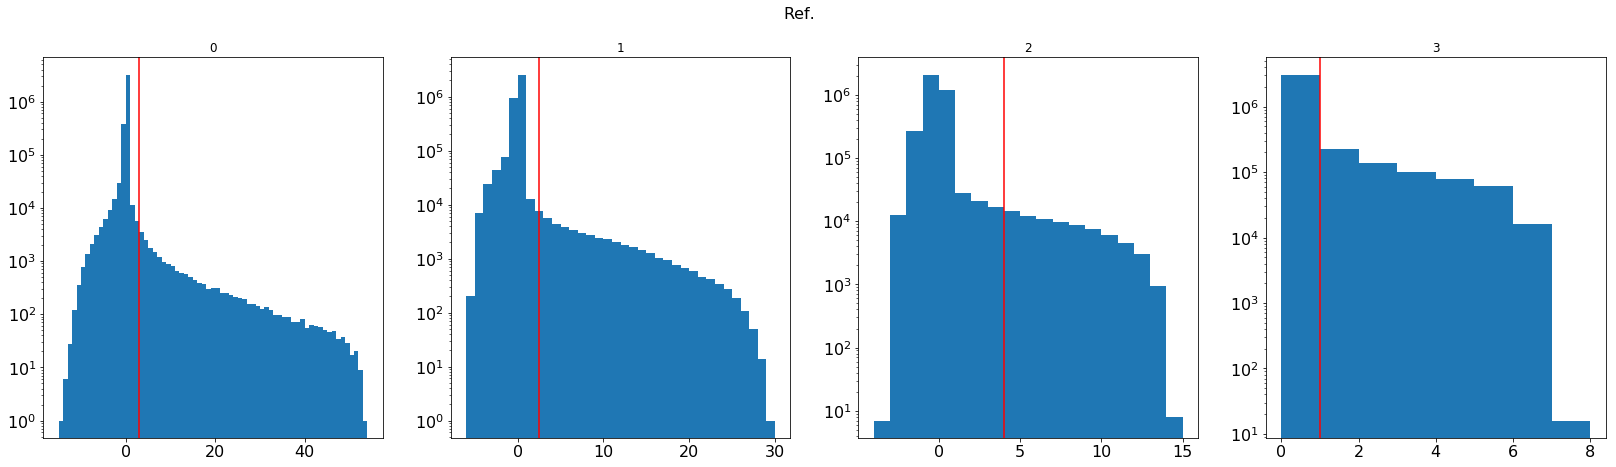

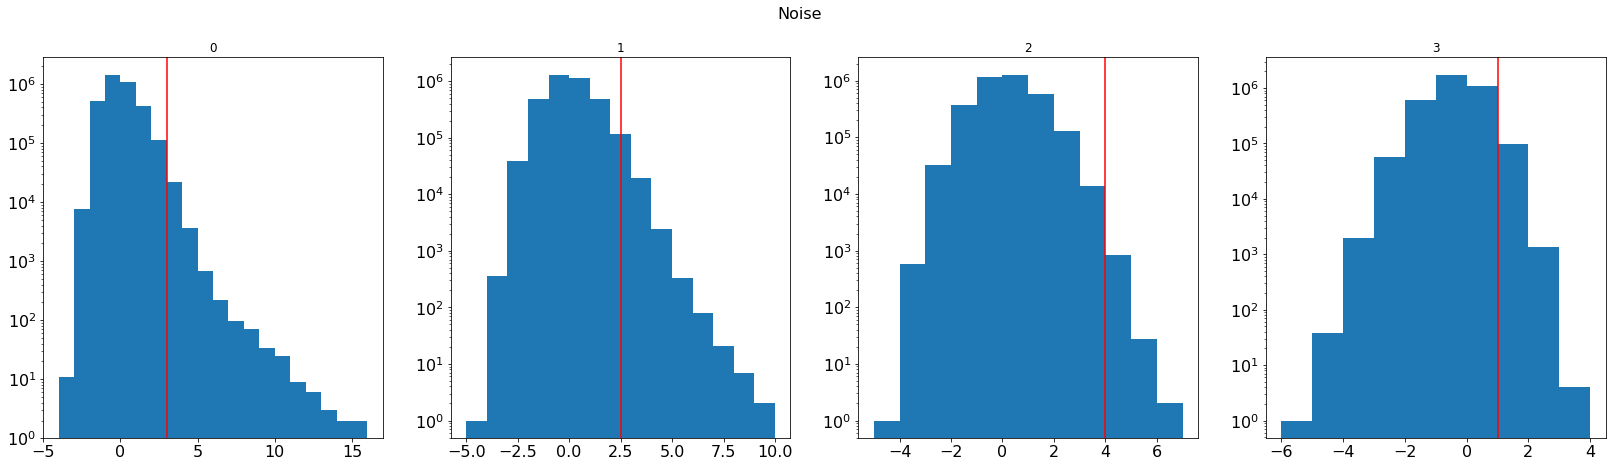

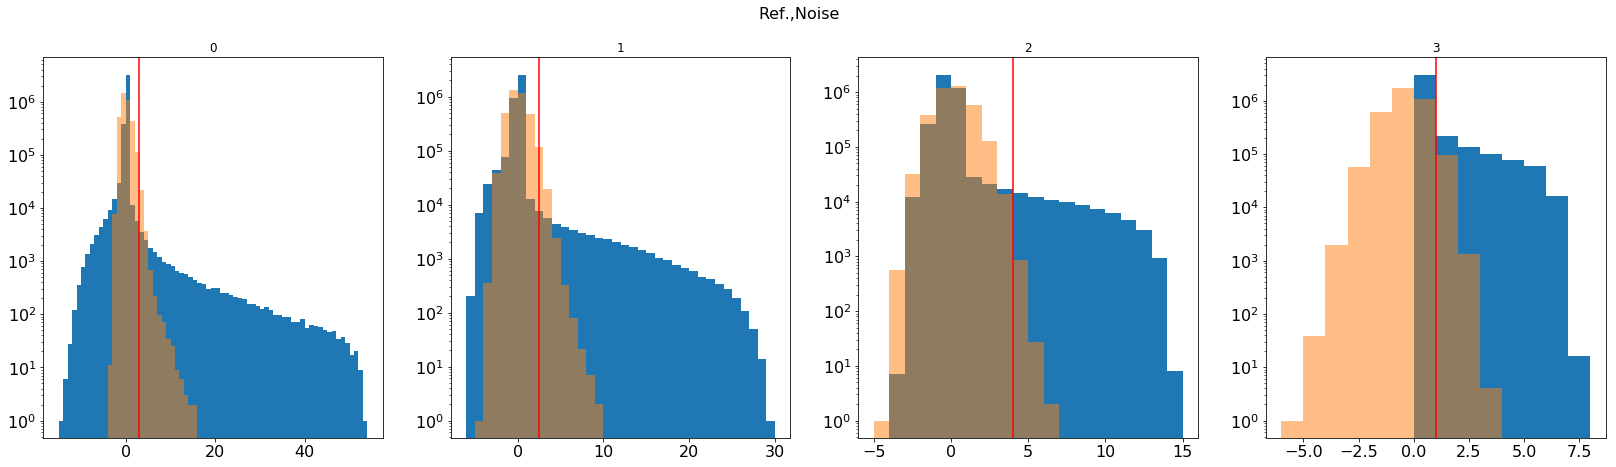

In [8]:
nectarcam_thresholds = [3, 2.5, 4, 1]

plot_hist(nectarcam_samples[0], threshold_list=nectarcam_thresholds, suptitle="Input")
plot_hist(nectarcam_samples[1], threshold_list=nectarcam_thresholds, suptitle="Ref.")
plot_hist(nectarcam_samples[2], threshold_list=nectarcam_thresholds, suptitle="Noise")

plot_hist(nectarcam_samples[1], threshold_list=nectarcam_thresholds, data_list2=nectarcam_samples[2], suptitle="Ref.,Noise")

## LSTCam

In [9]:
%%time

path_list = ['/Users/jdecock/data/grid_prod3b_north/fits/lst/gamma/']

lstcam_samples = make_samples(path_list,
                              tel_filter_list=None,
                              max_num_images=2000)

CPU times: user 1min 20s, sys: 38.8 s, total: 1min 58s
Wall time: 27min 28s


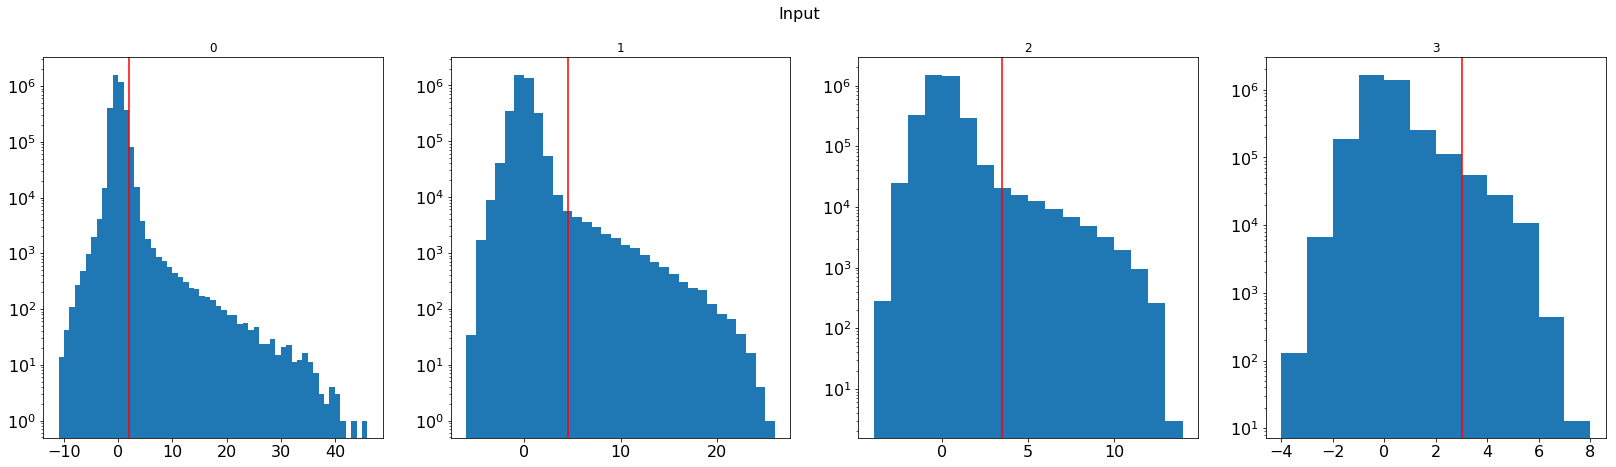

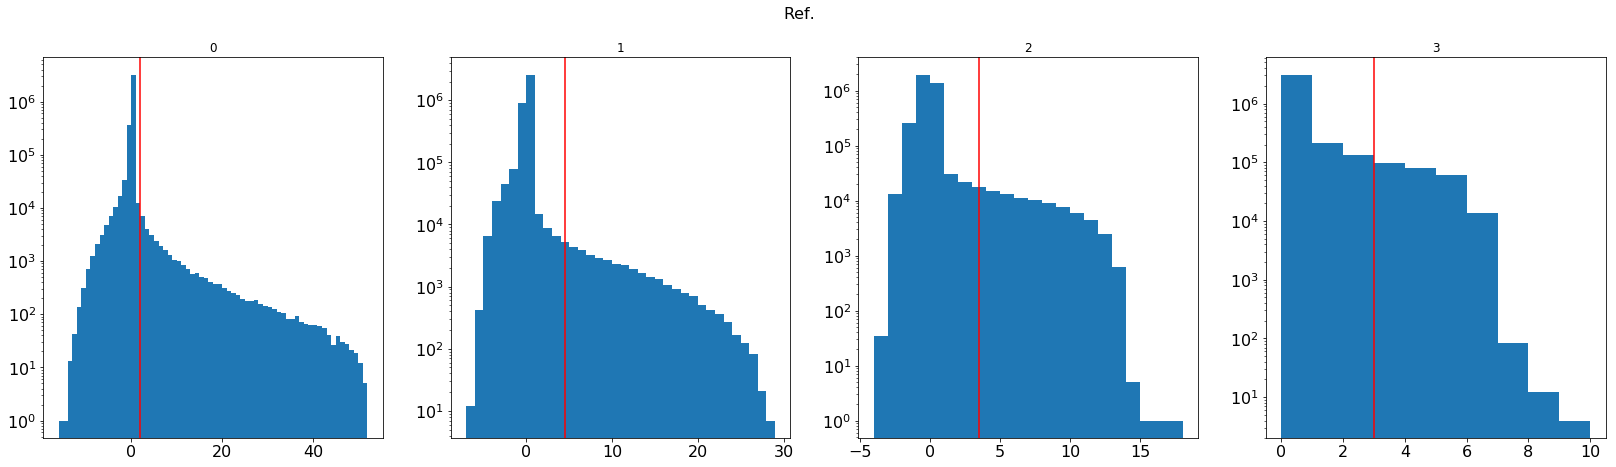

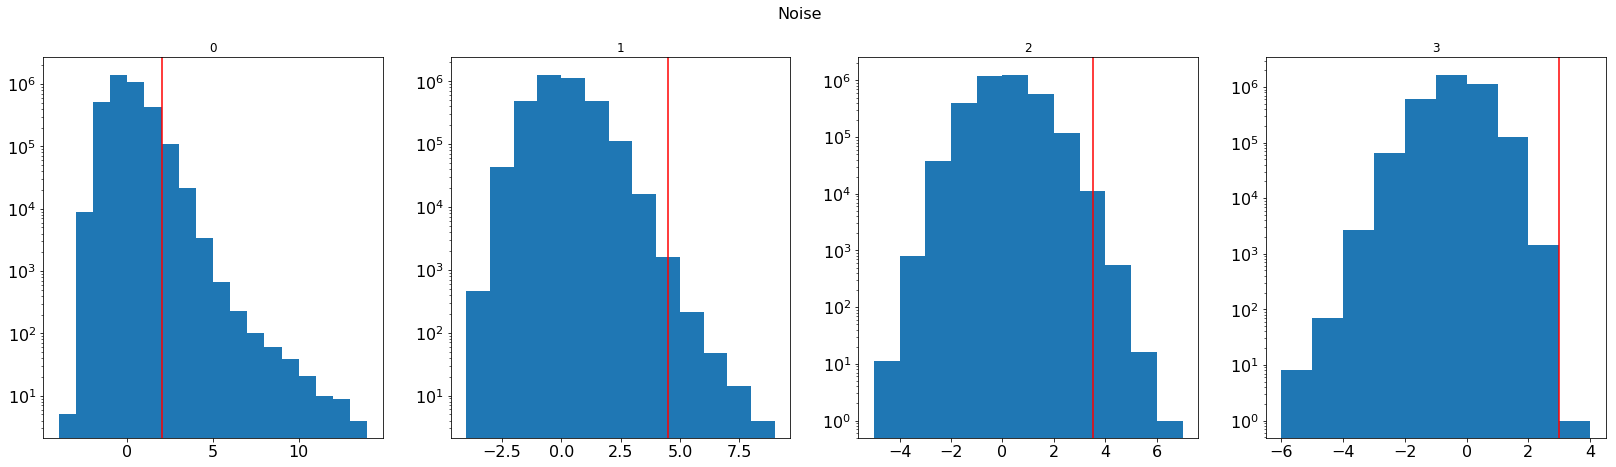

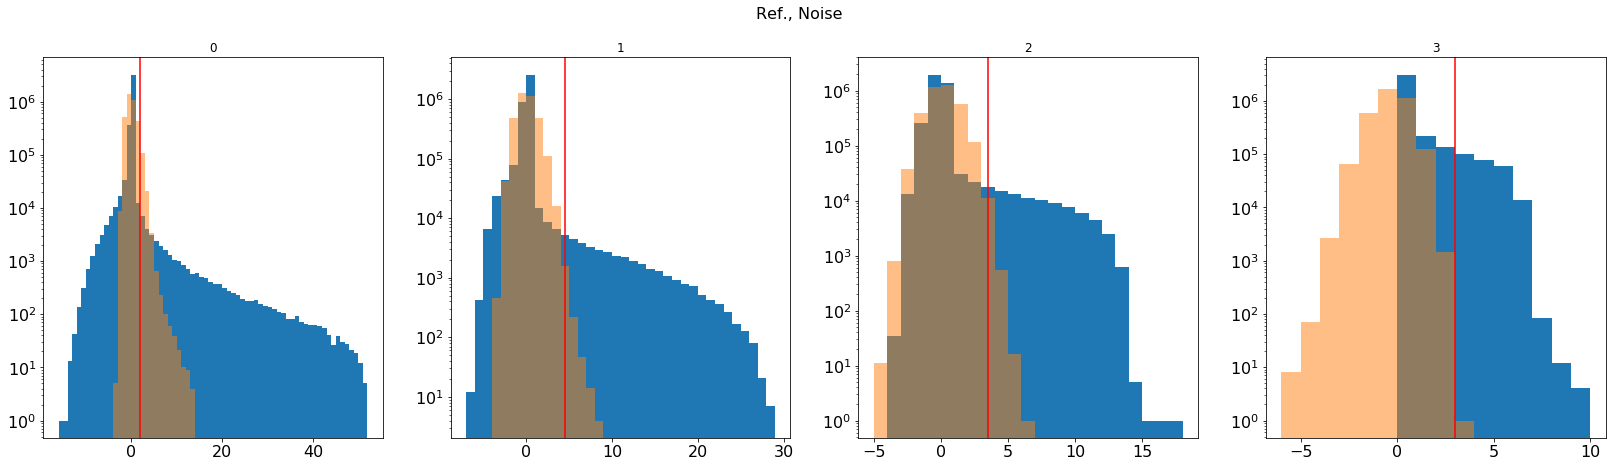

In [10]:
lstcam_thresholds = [2, 4.5, 3.5, 3]

plot_hist(lstcam_samples[0], threshold_list=lstcam_thresholds, suptitle="Input")
plot_hist(lstcam_samples[1], threshold_list=lstcam_thresholds, suptitle="Ref.")
plot_hist(lstcam_samples[2], threshold_list=lstcam_thresholds, suptitle="Noise")

plot_hist(lstcam_samples[1], threshold_list=lstcam_thresholds, data_list2=lstcam_samples[2], suptitle="Ref., Noise")

Wavelet thresholds should not be outside the Noise histogram range.